In [86]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [49]:
#WILL BE TRAINING MY OWN MODEL

#loading pretrained model
# filename = 'GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)

# glove_input_file = 'glove.6B/glove.6B.50d.txt'
# word2vec_output_file = 'glove.6B.50d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)
# filename = 'glove.6B.50d.txt.word2vec'
# model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [50]:
# model['%']

In [63]:
#loading data
headlines = pd.read_csv('FiQA_train_ABSA_financial_headlines.tsv',delimiter='\t',header=0)
posts = pd.read_csv('FiQA_train_ABSA_financial_posts.tsv',delimiter='\t',header=0)
posts = posts.drop(['Unnamed: 0', 'id'],axis=1)
headlines = headlines.drop(['Unnamed: 0', 'id'],axis=1)
posts_text = posts.iloc[:,:1]
posts_score = posts.iloc[:,1:]
headlines_text = headlines.iloc[:,:1]
headlines_score = headlines.iloc[:,1:]
text_frames = [posts_text,headlines_text]
score_frames = [posts_score,headlines_score]
text = pd.concat(text_frames)
score = pd.concat(score_frames)

In [70]:
sentences = [x for x in text['text']]
sentences

['$ZSL looking very weak, could be a good short setup.',
 '$ZNGA http://stks.co/3rdu Looking for a test at 9.25 resistance point. cc @ cfrazierjr @FletchTrade #traders',
 '$ZNGA did they prerelease sh*tty earnings or something',
 '#ContrarianAlert: Why Zynga Failed - http://stks.co/mC0R $ZNGA',
 '@IfHeDiesHeDies: @Bullhorn334: $ZNGA shorts are getting nervous""',
 '$ZNGA it\'s the times when you start to wonder "do i have enough shares ??? this beast keeps moving.."',
 '$EA points to the two Facebook games and accuses $ZNGA of copyright infringement. http://stks.co/g3A1',
 "Following this morning's EPS, I blew out $ZMH and added to $DNKN (longs)",
 "@dolleyman No worries, I always said there`d be sucker rallies on $ZIOP 's down trend, congrats.",
 "$ZC_F One thing you can't short here is $DBA food. Its barely getting warm in chicago, and it looks like drought conditions in soil already",
 '$ZAGG getting ready...Target $15 plus on a close over $13.50 on better than avg daily Volume http

In [71]:
def clean_sentences(sentence):
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)#removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)#removes links
#     sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split()) 
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)# remove @usernames
    sentence = sentence.replace('#','')#remove # from #tags
    return sentence

In [72]:
for i in range(len(sentences)):
    sentences[i] = clean_sentences(sentences[i])
sentences

['$ZSL looking very weak, could be a good short setup.',
 '$ZNGA  Looking for a test at 9.25 resistance point. cc @ cfrazierjr  traders',
 '$ZNGA did they prerelease sh*tty earnings or something',
 'ContrarianAlert: Why Zynga Failed -  $ZNGA',
 '  $ZNGA shorts are getting nervous""',
 '$ZNGA it\'s the times when you start to wonder "do i have enough shares ? this beast keeps moving.."',
 '$EA points to the two Facebook games and accuses $ZNGA of copyright infringement. ',
 "Following this morning's EPS, I blew out $ZMH and added to $DNKN (longs)",
 " No worries, I always said there`d be sucker rallies on $ZIOP 's down trend, congrats.",
 "$ZC_F One thing you can't short here is $DBA food. Its barely getting warm in chicago, and it looks like drought conditions in soil already",
 '$ZAGG getting ready.Target $15 plus on a close over $13.50 on better than avg daily Volume ',
 '$YUM OPPY reduces its price target on Yum Brands (YUM) to $74 from $82 after factoring in the troubles the compan

In [73]:
#finding sentence with max len
max_ = [len(x.split()) for x in sentences]

Populating the interactive namespace from numpy and matplotlib


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([0.00973781, 0.03922425, 0.10438565, 0.06188513, 0.03804115,
        0.03467387, 0.02557312, 0.024117  , 0.00591549, 0.00127411]),
 array([ 2. ,  4.9,  7.8, 10.7, 13.6, 16.5, 19.4, 22.3, 25.2, 28.1, 31. ]),
 <a list of 10 Patch objects>)

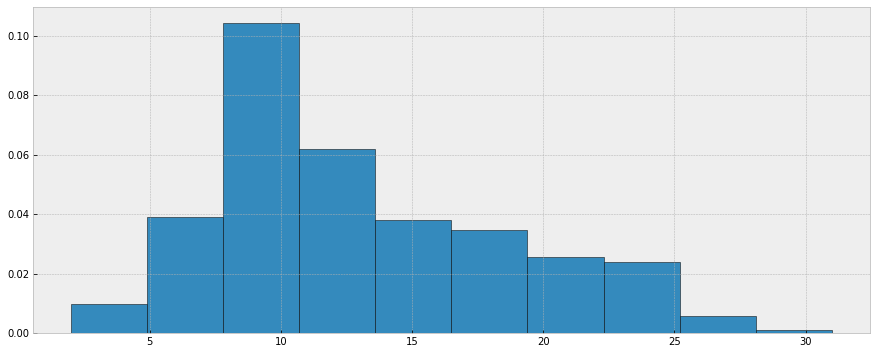

In [74]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%pylab inline
plt.style.use('bmh')
pylab.rcParams['figure.figsize'] = (15, 6)
plt.hist(max_, normed=True,edgecolor='black')

In [75]:
max(max_)

31

In [76]:
#max len is 31, not a lot of sentence with len more than 25 so max len be 25
max_len = 25

In [77]:
#loading trained model, if not present than train you own vocab
try: 
    model = Word2Vec.load('vocab_model.bin')
    print("model loaded form file")
except FileNotFoundError:
    print("traning new model")
    train_data_vocab = [x.split() for x in sentences]    
    model = Word2Vec(train_data_vocab,size=10, min_count=5,workers=4) #trying a 10 dimensional vector first
    model.save('vocab_model.bin')

model loaded form file


In [78]:
# 

In [124]:
def get_word_vector(sentence):
    vector = []
    for word in sentence.split():
        try:
            vector +=list(model[word])
        except KeyError:
            vector+=[0]*10
    return np.array(vector,dtype=float32)

In [125]:
# get_word_vector("test good").shape

In [126]:
# get_word_vector(sentences[0])
text_vectors = [get_word_vector(sentence) for sentence in sentences]

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [128]:
text_vectors = np.array(text_vectors)
# text_vectors[1]
# count = [x.shape[0] for x in text_vectors]
# count

In [130]:
#padding every vector to maxlen
for i in range(len(text_vectors)):
    text_vectors = tflearn.data_utils.pad_sequences(text_vectors, maxlen=max_len*10, value=0.)

In [ ]:
text_vectors

In [108]:
#converting scores into positive and negative classes
Y = (score>=0).astype(np.int_)
Y['sentiment score'].value_counts()

1    2407
0    1382
Name: sentiment score, dtype: int64

In [109]:
shuffle = np.arange(len(score))
np.random.shuffle(shuffle)
test_train_split = 0.9
train_split, test_split = shuffle[:int(len(score)*test_train_split)], shuffle[int(len(score)*test_train_split):]

In [117]:
# trainX, trainY = text_vectors[train_split,:], to_categorical(Y.values[train_split].ravel(), 2)
# testX, testY = text_vectors[test_split,:], to_categorical(Y.values[test_split].ravel(), 2)